# CATHODE Walkthrough

This is a simple conceptual guide through how the [CATHODE method](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.106.055006) for anomaly detection works. The notebook is oversimplified such that it does not make use of all optimization measures implemented in the main paper. It rather shows the core concept while hiding the technical implementation details behind a scikit-learn style API.

The core assumption of CATHODE is that you have a resonant feature $m$, in which a potential (a-priori unknown) signal process is localized. Furthermore, we want to make use of extra dimensions, our auxiliary features $x$, to discriminate between such a signal and the background. This is illustrated below.

![resonant anomaly detection](images/resonant_anomaly_detection.png)

We would now like to train a neural network classifier in a data-driven manner, such that it learns to classify signal from background. For this aim, we first divide the $m$ spectrum into a signal region (SR), in which we want to look for a localized signal, and the complementary sidebands (SB).

Then we train a conditional normalizing flow to learn the background distribution in $x$ as a function of $m$ from the SB and interpolate into the SR. Sampling from this model will yield an in-situ simulation of just the background.

Finally, we train our classifier to distinguish between the actual data in SR from this learned background template. If there is indeed signal, and it (over-)populates phase space regions in $x$, then this will be the only difference between the two classes. The classifier will thus learn to assign a higher output score to signal data points. This is an anomaly score that we can select on and it will thus increase the relative fraction of signal over background.

These steps are now illustrated via code below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys

from os.path import exists, join, dirname, realpath
from sklearn.metrics import roc_curve
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.generative_models.conditional_normalizing_flow_torch import ConditionalNormalizingFlow
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier
from sk_cathode.utils.preprocessing import LogitScaler

In [3]:
# :sunglasses:
plt.style.use('dark_background')

The input data are preprocessed via another script `demos/utils/data_preparation.py`. It downloads the LHCO R\&D dataset and applies the preprocessing to extract the conditional feature $m=m_{jj}$ and four auxiliary features $x=(m_{j1}, \Delta m_{jj}, \tau_{21,j1}, \tau_{21,j2})$. Moreover, it divides the $m$ spectrum into SR and SB, and splits the data into training/validation/test sets.

In [4]:
data_path = "./input_data/"

In [5]:
# data preparation (download and high-level preprocessing)
if not exists(join(data_path, "innerdata_test.npy")):
    process = subprocess.run(f"{sys.executable} {join(parent_dir, 'demos', 'utils', 'data_preparation.py')} --outdir {data_path}", shell=True, check=True)


In [20]:
# data loading
outerdata_train = np.load(join(data_path, "outerdata_train.npy"))
outerdata_val = np.load(join(data_path, "outerdata_val.npy"))
innerdata_train = np.load(join(data_path, "innerdata_train.npy"))
innerdata_val = np.load(join(data_path, "innerdata_val.npy"))
innerdata_test = np.load(join(data_path, "innerdata_test.npy"))

print(outerdata_train.shape)
#print(f"outerdata_train:\n{outerdata_train[:3]}")
#print(f"outerdata_val:\n{outerdata_train[:3]}")
#print(f"inerdata_train:\n{outerdata_train[:3]}")
#print(f"innerdata_val:\n{outerdata_train[:3]}")
#print(f"innerdata_test:\n{outerdata_train[:3]}")

print(outerdata_val.shape)

(439125, 6)
innerdata_test:
[[2.87944598 0.0964973  0.1988517  0.55157483 0.67305546 0.        ]
 [5.73241976 0.152129   0.357397   0.65298791 0.5270039  0.        ]
 [4.25985144 0.0692866  0.24275341 0.91029904 0.59295812 0.        ]
 [2.56054859 0.0642991  0.21236688 0.7195469  0.67446875 0.        ]
 [3.90795792 0.0590095  0.46566848 0.73785788 0.29927955 0.        ]
 [3.12117785 0.18550999 0.235416   0.47245574 0.48450364 0.        ]
 [2.64464374 0.106139   0.262124   0.47584986 0.38780001 0.        ]
 [2.45009648 0.0616352  0.20932381 0.62988972 0.87171103 0.        ]
 [2.68854449 0.0809687  0.0146478  0.42159291 0.51990938 0.        ]
 [2.05278312 0.0837621  0.10597591 0.31006632 0.43660488 0.        ]
 [2.67129331 0.0844078  0.31078919 0.64318507 0.17176611 0.        ]
 [2.44037565 0.0555321  0.2256229  0.42737836 0.08664325 0.        ]
 [1.88372376 0.0669386  0.12616141 0.45751285 0.39843996 0.        ]
 [2.61100563 0.0787756  0.19844541 0.72141273 0.27767977 0.        ]
 [2.57

Now the conditional normalizing flow is trained on SB data. Since flows learn a smooth mapping, it is hard for them to learn steep edges. Thus, we first apply a logit transformation to smoothen out the boundaries and then apply a standard scaler transformation to normalize the data to zero mean and unit variance. The flow is then trained on these transformed data.

In [7]:
# either train new flow model from scratch

# We streamline the preprocessing with an sklearn pipeline. 
outer_scaler = make_pipeline(LogitScaler(), StandardScaler())

m_train = outerdata_train[:, 0:1]
X_train = outer_scaler.fit_transform(outerdata_train[:, 1:-1])
m_val = outerdata_val[:, 0:1]
X_val = outer_scaler.transform(outerdata_val[:, 1:-1])

flow_savedir = "./trained_flows/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(flow_savedir, "DE_models")):
    flow_model = ConditionalNormalizingFlow(save_path=flow_savedir,
                                            num_inputs=outerdata_train[:, 1:-1].shape[1],
                                            early_stopping=True, epochs=None,
                                            verbose=True)
    flow_model.fit(X_train, m_train, X_val, m_val)
else:
    print(f"The model exists already in {flow_savedir}. Remove first if you want to overwrite.")

The model exists already in ./trained_flows/. Remove first if you want to overwrite.


In [23]:
# or loading existing flow model

outer_scaler = make_pipeline(LogitScaler(), StandardScaler())
outer_scaler.fit(outerdata_train[:, 1:-1])

flow_savedir = "./trained_flows/"
flow_model = ConditionalNormalizingFlow(save_path=flow_savedir,
                                        num_inputs=outerdata_train[:, 1:-1].shape[1],
                                        load=True)

ConditionalNormalizingFlow has 274800 parameters


/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/generative_models/conditional_normalizing_flow_torch.py:625: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.

We now have a trained flow model that samples data in $x$ for given values in $m$. We simply interpolate this SB-trained model into the SR by plugging corresponding $m$ values into the sampling method of the model. However, this requires us to first sample a realistic distribution of SR $m$ values. We do this by learning a simple 1D kernel density estimator (KDE) on $m$ values within the SR. From this KDE model we sample now as many values as we want SR samples. We can in fact sample more background events than we have data, as long as we apply proper weights in the classifier training later.

For the classifier training, we give this learned background template a label of 0.

In [9]:
# fitting a KDE for the mass distribution based on the inner training set

# we also perform a logit first to stretch out the hard boundaries
m_scaler = LogitScaler(epsilon=1e-8)
m_train = m_scaler.fit_transform(innerdata_train[:, 0:1])

kde_model = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_model.fit(m_train)

# now let's sample 4x the number of training data
m_samples = kde_model.sample(4*len(m_train)).astype(np.float32)
m_samples = m_scaler.inverse_transform(m_samples)

In [10]:
# drawing samples from the flow model with the KDE samples as conditional
X_samples = flow_model.sample(n_samples=len(m_samples), m=m_samples)

X_samples = outer_scaler.inverse_transform(X_samples)

# assigning "signal" label 0 to samples
samples = np.hstack([m_samples, X_samples, np.zeros((m_samples.shape[0], 1))])

Since in this case we know beforehand which data points are signal and which are background, we can exactly compare the learned background template to the actual background within the (simulated) SR dataset.

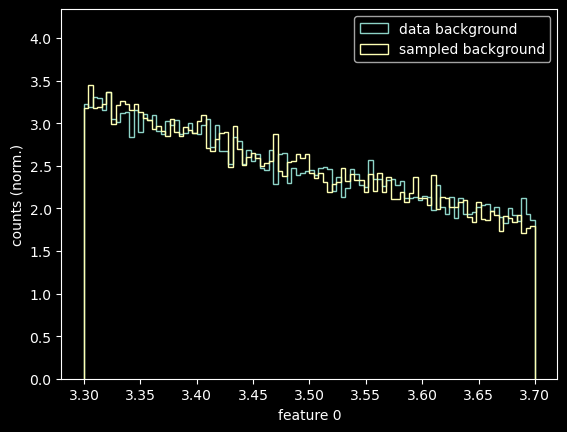

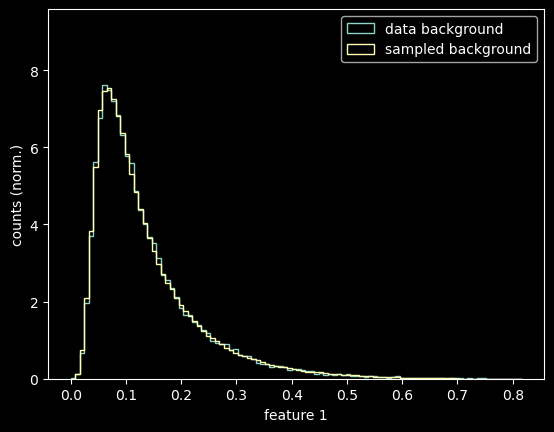

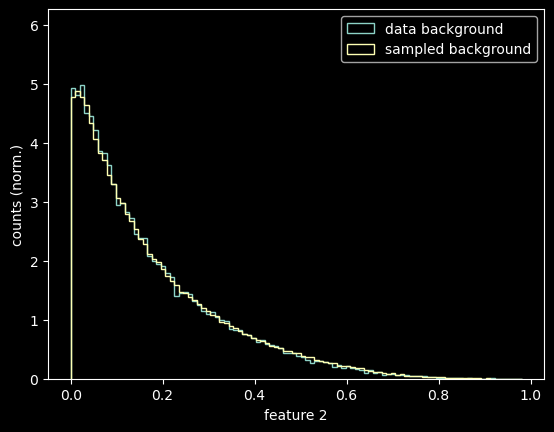

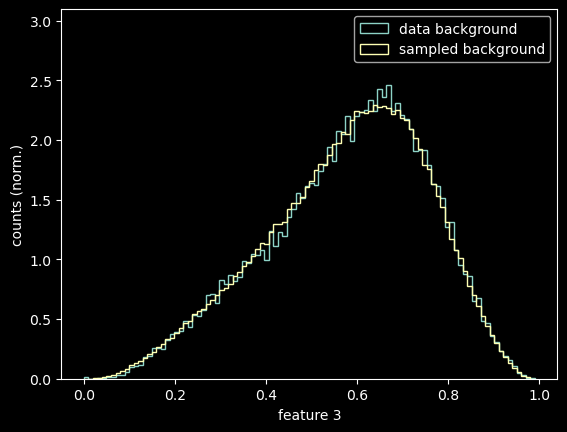

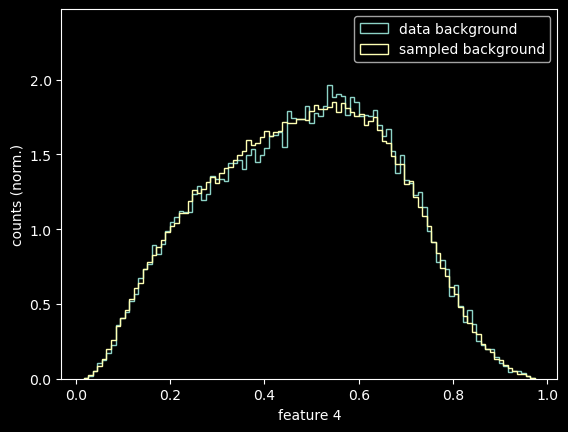

In [11]:
# comparing samples to inner background (idealized sanity check)

for i in range(innerdata_test[:, :-1].shape[1]):
    _, binning, _ = plt.hist(innerdata_test[innerdata_test[:, -1] == 0, i],
                             bins=100, label="data background",
                             density=True, histtype="step")
    _ = plt.hist(samples[:, i],
                 bins=binning, label="sampled background",
                 density=True, histtype="step")
    plt.legend()
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.2)
    plt.xlabel("feature {}".format(i))
    plt.ylabel("counts (norm.)")
    plt.show()

The entire SR dataset is assigned a label of 1 for the classifier training. Contrary to the standard fully supervised training, where you assign a label of 1 to signal and 0 to background, this so-called weakly supervised learning aims at distinguishing two almost equal samples: the data (background + small signal) from pure background (the learned background template). One can [show](https://link.springer.com/article/10.1007/JHEP10(2017)174) that this training will still (under optimal conditions) yield a classifier that assigns a higher score to signal than to background.

In [12]:
# assigning "signal" label 1 to data
clsf_train_data = innerdata_train.copy()
clsf_train_data[:, -1] = np.ones_like(clsf_train_data[:, -1])

clsf_val_data = innerdata_val.copy()
clsf_val_data[:, -1] = np.ones_like(clsf_val_data[:, -1])

# then mixing data and samples into train/val sets together proportionally
n_train = len(clsf_train_data)
n_val = len(clsf_val_data)
n_samples_train = int(n_train / (n_train + n_val) * len(samples))
samples_train = samples[:n_samples_train]
samples_val = samples[n_samples_train:]

clsf_train_set = np.vstack([clsf_train_data, samples_train])
clsf_val_set = np.vstack([clsf_val_data, samples_val])
clsf_train_set = shuffle(clsf_train_set, random_state=42)
clsf_val_set = shuffle(clsf_val_set, random_state=42)

Now we train the weakly supervised classifier. The neural network classifier here automatically assigns class weights, such that the data and background template contributes equally to the learning.

In [13]:
# either train new NN classifier to distinguish between real inner data and samples

# derive scaler parameters on data only, so it stays the same even if we resample
inner_scaler = StandardScaler()
inner_scaler.fit(clsf_train_data[:, 1:-1])

X_train = inner_scaler.transform(clsf_train_set[:, 1:-1])
y_train = clsf_train_set[:, -1]
X_val = inner_scaler.transform(clsf_val_set[:, 1:-1])
y_val = clsf_val_set[:, -1]

print(f"X_train:{X_train.shape}, y_train:{y_train.shape}, X_val:{X_val.shape}, y_val:{y_val.shape}")

classifier_savedir = "./trained_classifiers/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(classifier_savedir, "CLSF_models")):
    classifier_model = NeuralNetworkClassifier(save_path=classifier_savedir,
                                               n_inputs=X_train.shape[1],
                                               early_stopping=True, epochs=None,
                                               verbose=True)
    classifier_model.fit(X_train, y_train, X_val, y_val)
else:
    print(f"The model exists already in {classifier_savedir}. Remove first if you want to overwrite.")

X_train:(245949, 4), y_train:(245949,), X_val:(81185, 4), y_val:(81185,)
The model exists already in ./trained_classifiers/. Remove first if you want to overwrite.


In [14]:
# or alternatively load existing classifer model

inner_scaler = StandardScaler()
inner_scaler.fit(clsf_train_data[:, 1:-1])

classifier_savedir = "./trained_classifiers/"
classifier_model = NeuralNetworkClassifier(save_path=classifier_savedir,
                                           n_inputs=clsf_train_data[:, 1:-1].shape[1],
                                           load=True)

/gpfs/dust/maxwell/user/yedechit/sk_cathode/sk_cathode/classifier_models/neural_network_classifier.py:385: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

Let's evaluate how well this classifier performs in terms of distinguishing signal from background. We can of course only do this because we have the true labels for this simulation, which we don't in a real analysis.

We quantify the performance via the significance improvement characteristic (SIC), which measures the significance via $S/\sqrt{B}$ after applying a selection on the classifier output divided by the unselected significance. The true positive rate in the horizontal axis quantifies how tightly we apply this cut on the anomaly score.

So higher numbers are better and we should see a non-trivial (non-random and even $>1$) SIC for CATHODE, which means that we substantially improve the significance of the signal over background in the analysis, even without ever showing true signal labels to the classifier during training.

X_test:(40490, 4)
X_test:
[[-0.35494033 -0.74992233 -0.11829278  0.90063593]
 [ 0.68156739 -0.87899289 -0.77065693  0.34954962]
 [-1.09391054  0.6522332   1.07031803 -0.90057402]]
y_test:(40490,)
y_test:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
True
preds_test:
[[0.5062996]
 [0.4917084]
 [0.4985315]]
[0.         0.         0.         ... 0.99500534 0.99500534 1.        ] [0.         0.00404858 0.01214575 ... 0.99595142 1.         1.        ]


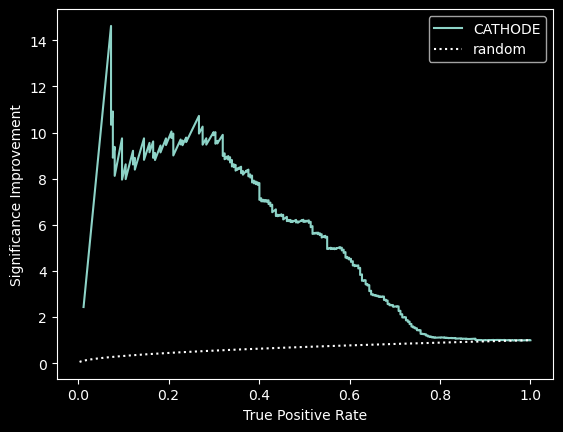

In [21]:
# now let's evaluate the signal extraction performance

X_test = inner_scaler.transform(innerdata_test[:, 1:-1])
y_test = innerdata_test[:, -1]

print(f"X_test:{X_test.shape}")
print(f"X_test:\n{X_test[:3]}")
print(f"y_test:{y_test.shape}")
print(f"y_test:\n{y_test[:50]}")

has_one = np.any(y_test == 1)
print(has_one)

preds_test = classifier_model.predict(X_test)
print(f"preds_test:\n{preds_test[:3]}")


with np.errstate(divide='ignore', invalid='ignore'):
    fpr, tpr, _ = roc_curve(y_test, preds_test)
    print(fpr,tpr)
    sic = tpr / np.sqrt(fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_sic = random_tpr / np.sqrt(random_tpr)

plt.plot(tpr, sic, label="CATHODE")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()